![Python_logo](https://www.python.org/static/community_logos/python-logo-master-v3-TM.png)


  # **Cortex Game: Round2--Probability of Giving**

> Before playing the game, you need to connect to SASPy first.
>
>> If it is your first time, please follow the 4 steps mentioned below!

***
## **Connect to SASPy**

**1- Make sure that your Python version is 3.3 or higher**

In [1]:
from platform import python_version
print (python_version())

3.9.13


**2- Install SASPy**

In [2]:
pip install saspy

Note: you may need to restart the kernel to use updated packages.


**3- Make sure that the configuration file "sascfg_personal.py" is correctly created**

In [3]:
import saspy, os
print(saspy.__file__.replace('__init__.py', 'sascfg_personal.py'))

C:\Users\CarlosD\anaconda3\lib\site-packages\saspy\sascfg_personal.py


**4- Establish Connection (Need to do this step each time you use SASPy)**

In [4]:
import saspy
sas_session = saspy.SASsession()
sas_session

Using SAS Config named: oda
SAS Connection established. Subprocess id is 17644



Access Method         = IOM
SAS Config name       = oda
SAS Config file       = C:\Users\CarlosD\anaconda3\lib\site-packages\saspy\sascfg_personal.py
WORK Path             = /saswork/SAS_workD09800017582_odaws03-usw2.oda.sas.com/SAS_work8B4D00017582_odaws03-usw2.oda.sas.com/
SAS Version           = 9.04.01M6P11072018
SASPy Version         = 4.4.0
Teach me SAS          = False
Batch                 = False
Results               = Pandas
SAS Session Encoding  = utf-8
Python Encoding value = utf-8
SAS process Pid value = 95618


***
## Connect to Cortex Data Sets

Load Cortex datasets from SAS Studio

In [5]:
%%SAS sas_session

libname cortex '~/my_shared_file_links/u39842936/Cortex Data Sets';

### Transform cloud SAS dataset to Python dataframe (pandas)

For reference: 

1. [Pandas library](https://pandas.pydata.org/docs/user_guide/index.html)


2. [sklearn.model_selection for data partition](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [6]:
import pandas as pd

data1 = sas_session.sasdata2dataframe(
table='hist',
libref='cortex'
)

data2 = sas_session.sasdata2dataframe(
table='target_rd2',
libref='cortex'
)

## Merge the Data

In [7]:
data_merge = pd.merge(data1, data2, on=["ID"],how="right")
#data_merge.head()
data_merge.sample(2)

,ID,LastName,FirstName,Woman,Age,Salary,Education,City,SeniorList,NbActivities,...,Frequency,Seniority,TotalGift,MinGift,MaxGift,GaveLastYear,AmtLastYear,Contact,GaveThisYear,AmtThisYear
52187,2052188.0,ALLEN,ERNA,1.0,58.0,10500.0,University / College,City,6.0,1.0,...,2.0,6.0,50.0,20.0,30.0,0.0,0.0,0.0,0.0,0.0
372903,2372904.0,BURDOCK,SALLY,1.0,60.0,32800.0,University / College,City,7.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0


## Treating Missing Values

Please be aware that deleting all missing values can induce a selection bias. 
Some missing values are very informative. For example, when MinGift is missing, it means that the donor never gave in the past 10 years (leading to but excluding last year). Instead of deleting this information, replacing it by 0 is more appropriate!

A good understanding of the business case and the data can help you come up with more appropriate strategies to deal with missing values.

In [8]:
# In this case, we are replacing MinGift with 0.
# You can do the same for what you think is reasonable for dealing with the other variables.

data_merge[['MinGift']] = data_merge[['MinGift']].fillna(value=0)
data_merge[['MaxGift']] = data_merge[['MinGift']].fillna(value=0)
data_merge[['TotalGift']] = data_merge[['MinGift']].fillna(value=0)

In [9]:
data_merge.loc[data_merge["Education"] == "Elementary", "Education"] = 0

data_merge.loc[data_merge["Education"] == "High School", "Education"] = 1

data_merge.loc[data_merge["Education"] == "University / College", "Education"] = 2

dummies = pd.get_dummies(data_merge['City'], drop_first = True)
#dummies.head()

# Añadimos las variables binarias al DataFrame
data_merge = pd.concat([data_merge, dummies], axis = 1)

# Eliminamos la vairable original
data_merge = data_merge.drop(columns=['City'])

data_merge.sample(3)

,ID,LastName,FirstName,Woman,Age,Salary,Education,SeniorList,NbActivities,Referrals,...,MinGift,MaxGift,GaveLastYear,AmtLastYear,Contact,GaveThisYear,AmtThisYear,Downtown,Rural,Suburban
579502,2579503.0,GARCIA,EMILY,1.0,49.0,234800.0,2,3.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
667813,2667814.0,RAMIREZ,LISA,1.0,84.0,59000.0,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,40.0,0,1,0
597725,2597726.0,HUNT,NOAH,0.0,61.0,150500.0,2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0


## Data Partition

In [10]:
# The code below is an illustration on how to sample data on train and validation samples.
# You could use another library or a built-in function to perform sampling.

from sklearn.model_selection import train_test_split
train, validation = train_test_split(data_merge, test_size=0.4, random_state=12345) 

#train.head()
train.sample(2)

,ID,LastName,FirstName,Woman,Age,Salary,Education,SeniorList,NbActivities,Referrals,...,MinGift,MaxGift,GaveLastYear,AmtLastYear,Contact,GaveThisYear,AmtThisYear,Downtown,Rural,Suburban
504938,2504939.0,VARGAS,DAN,0.0,51.0,67300.0,1,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
437387,2437388.0,STEVENS,CHRISTOPHER,0.0,30.0,48300.0,2,6.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0


# Prebuilt Models

The sk-learn library offers more advanced models. 

sk-learn library: https://scikit-learn.org/stable/index.html  

## Logistic Regression Model

In [11]:
from sklearn.linear_model import LogisticRegression

#comment: it's numpy array ==> categorical variables
X_train = train[['Age', 'Salary','MinGift', 'GaveLastYear','Contact', 'Woman', 'NbActivities', 'Education', 'Downtown', 'Rural', 'Suburban', 'SeniorList', 'Referrals', 'MaxGift', 'TotalGift']] 
Y_train = train['GaveThisYear']
X_valid = validation[['Age', 'Salary','MinGift', 'GaveLastYear','Contact', 'Woman', 'NbActivities', 'Education', 'Downtown', 'Rural', 'Suburban', 'SeniorList', 'Referrals', 'MaxGift', 'TotalGift']] 
Y_valid = validation['GaveThisYear']

regr = LogisticRegression()
regr.fit(X_train,Y_train)
regr_predict=regr.predict(X_valid)

In [12]:
#you can change the criteria

import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(Y_valid, regr_predict)
print(confusion_matrix)

[[340132     81]
 [ 59768     19]]


In [13]:
from sklearn.metrics import classification_report
print(classification_report(Y_valid, regr_predict))

              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92    340213
         1.0       0.19      0.00      0.00     59787

    accuracy                           0.85    400000
   macro avg       0.52      0.50      0.46    400000
weighted avg       0.75      0.85      0.78    400000



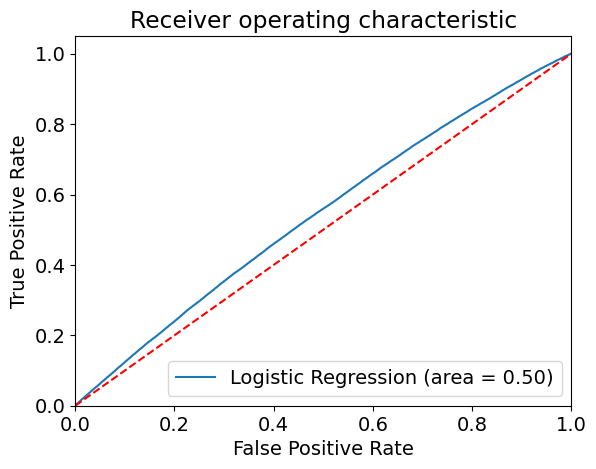

In [14]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt 
plt.rc("font", size=14)

logit_roc_auc = roc_auc_score(Y_valid, regr.predict(X_valid))
fpr, tpr, thresholds = roc_curve(Y_valid, regr.predict_proba(X_valid)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Decision Tree Model

In [15]:
from sklearn.tree import DecisionTreeClassifier

X_train = train[['Age','Salary','MinGift','GaveLastYear','Contact','Woman', 'NbActivities', 'Education', 'Downtown', 'Rural', 'Suburban', 'SeniorList', 'Referrals', 'MaxGift', 'TotalGift']] 
Y_train = train['GaveThisYear']
X_valid = validation[['Age','Salary','MinGift','GaveLastYear','Contact','Woman', 'NbActivities', 'Education', 'Downtown', 'Rural', 'Suburban', 'SeniorList', 'Referrals', 'MaxGift', 'TotalGift']] 
Y_valid = validation['GaveThisYear']

DT_model = DecisionTreeClassifier(max_depth=5,criterion="entropy").fit(X_train,Y_train)
DT_predict_proba = DT_model.predict_proba(X_valid) #Predictions on Testing data
DT_predict = DT_model.predict(X_valid) #Predictions on Testing data
# Probabilities for each class
DT_probs = DT_model.predict_proba(X_valid)[:, 1]
print(DT_probs)

[0.11072745 0.1603026  0.21281849 ... 0.10160446 0.56717476 0.06410951]


In [16]:
#you can change the criteria
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix


confusion_matrix = confusion_matrix(Y_valid, DT_predict)
print(confusion_matrix)


[[335351   4862]
 [ 52379   7408]]


In [17]:
from sklearn.metrics import classification_report
print(classification_report(Y_valid, DT_predict))

              precision    recall  f1-score   support

         0.0       0.86      0.99      0.92    340213
         1.0       0.60      0.12      0.21     59787

    accuracy                           0.86    400000
   macro avg       0.73      0.55      0.56    400000
weighted avg       0.83      0.86      0.81    400000



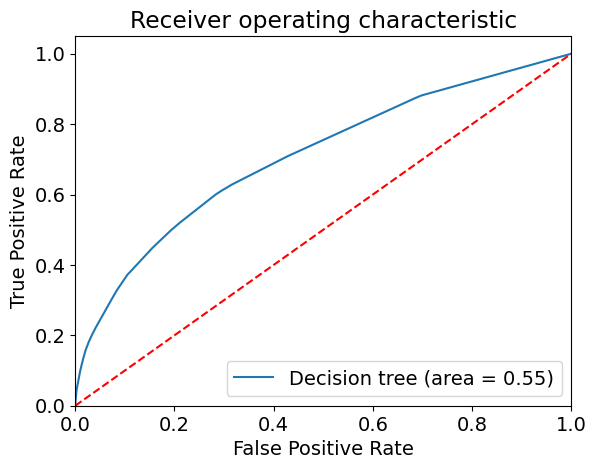

In [18]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt 
plt.rc("font", size=14)

DT_roc_auc = roc_auc_score(Y_valid, DT_model.predict(X_valid))
fpr, tpr, thresholds = roc_curve(Y_valid, DT_model.predict_proba(X_valid)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Decision tree (area = %0.2f)' % DT_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('DT_ROC')
plt.show()

### *Other models may also be helpful for this game*

Reference: https://scikit-learn.org/stable/supervised_learning.html
    

## Scoring New Data

### Prepare data for scoring

In [19]:
data3 = sas_session.sasdata2dataframe(
table='score',
libref='cortex'
)
data4 = sas_session.sasdata2dataframe(
table='score_rd2_contact',
libref='cortex'
)
data5 = sas_session.sasdata2dataframe(
table='SCORE_RD2_NOCONTACT',
libref='cortex'
)

 ### Score new data based on your champion model
 
 Pick your champion model from previous steps and use it to predict next year donations. 
 
 In this case, the Decision Tree model performed better than the Logistic Regression model based on the AUC criterion.

### Predict 'probability of giving' for members who were contacted

In [20]:
scoring_data_contact = pd.merge(data3, data4, on=["ID"],how="right")

# Perform the same strategy for handling missing values for the score dataset.
# In this case, we will only replace missing values of the MinGift variable.

scoring_data_contact[['MinGift']] = scoring_data_contact[['MinGift']].fillna(value=0)
scoring_data_contact[['MaxGift']] = scoring_data_contact[['MinGift']].fillna(value=0)
scoring_data_contact[['TotalGift']] = scoring_data_contact[['MinGift']].fillna(value=0)

scoring_data_contact.loc[scoring_data_contact["Education"] == "Elementary", "Education"] = 0

scoring_data_contact.loc[scoring_data_contact["Education"] == "High School", "Education"] = 1

scoring_data_contact.loc[scoring_data_contact["Education"] == "University / College", "Education"] = 2

dummies = pd.get_dummies(scoring_data_contact['City'], drop_first = True)
#dummies.head()

# Añadimos las variables binarias al DataFrame
scoring_data_contact = pd.concat([scoring_data_contact, dummies], axis = 1)

# Eliminamos la vairable original
scoring_data_contact = scoring_data_contact.drop(columns=['City'])


#scoring_data_contact.head()

X = scoring_data_contact[['Age','Salary','MinGift','GaveLastYear','Contact','Woman', 'NbActivities', 'Education', 'Downtown', 'Rural', 'Suburban', 'SeniorList', 'Referrals', 'MaxGift', 'TotalGift']] 
DT_predict_contact=DT_model.predict_proba(X)[:,1]
scoring_data_contact['Prediction_prob'] = DT_predict_contact

scoring_data_contact= scoring_data_contact[['ID','Prediction_prob']]
scoring_data_contact = scoring_data_contact.rename({'Prediction_prob': 'ProbContact'}, axis=1) 
scoring_data_contact.head()

,ID,ProbContact
0,2000001.0,0.308584
1,2000002.0,0.567175
2,2000003.0,0.567175
3,2000004.0,0.308372
4,2000005.0,0.567175


### Predict 'probability of giving' for members who were not contacted

In [21]:
scoring_data_nocontact = pd.merge(data3, data5, on=["ID"],how="right")

# Perform the same strategy for handling missing values for the score dataset.
# In this case, we will only replace missing values of the MinGift variable.

scoring_data_nocontact[['MinGift']] = scoring_data_nocontact[['MinGift']].fillna(value=0)
scoring_data_nocontact[['MaxGift']] = scoring_data_nocontact[['MinGift']].fillna(value=0)
scoring_data_nocontact[['TotalGift']] = scoring_data_nocontact[['MinGift']].fillna(value=0)

scoring_data_nocontact.loc[scoring_data_nocontact["Education"] == "Elementary", "Education"] = 0

scoring_data_nocontact.loc[scoring_data_nocontact["Education"] == "High School", "Education"] = 1

scoring_data_nocontact.loc[scoring_data_nocontact["Education"] == "University / College", "Education"] = 2

dummies = pd.get_dummies(scoring_data_nocontact['City'], drop_first = True)
#dummies.head()

# Añadimos las variables binarias al DataFrame
scoring_data_nocontact = pd.concat([scoring_data_nocontact, dummies], axis = 1)

# Eliminamos la vairable original
scoring_data_nocontact = scoring_data_nocontact.drop(columns=['City'])

#scoring_data_contact.head()

X = scoring_data_nocontact[['Age','Salary','MinGift','GaveLastYear','Contact','Woman', 'NbActivities', 'Education', 'Downtown', 'Rural', 'Suburban', 'SeniorList', 'Referrals', 'MaxGift', 'TotalGift']] 
DT_predict_nocontact=DT_model.predict_proba(X)[:,1]
scoring_data_nocontact['Prediction_prob'] = DT_predict_nocontact

scoring_data_nocontact= scoring_data_nocontact[['ID','Prediction_prob']]
scoring_data_nocontact = scoring_data_nocontact.rename({'Prediction_prob': 'ProbNoContact'}, axis=1) 
scoring_data_nocontact.head()

,ID,ProbNoContact
0,2000001.0,0.110727
1,2000002.0,0.064110
2,2000003.0,0.064110
3,2000004.0,0.064110
4,2000005.0,0.064110


In [22]:
result_Prob = pd.merge(scoring_data_contact, scoring_data_nocontact, on=["ID"],how="right")
result_Prob.sort_values(by=['ID'], inplace=True)
result_Prob.sample(10)

,ID,ProbContact,ProbNoContact
451283,2451284.0,0.653959,0.190842
221376,2221377.0,0.308584,0.064110
553923,2553924.0,0.308372,0.064110
682253,2682254.0,0.736216,0.400236
511465,2511466.0,0.308372,0.270436
991477,2991478.0,0.760452,0.101604
858364,2858365.0,0.313691,0.187477
681839,2681840.0,0.452727,0.101604
513911,2513912.0,0.567175,0.064110
641845,2641846.0,0.452727,0.101604


## Exporting Results to a CSV File

In [23]:
result_Prob.to_csv('Round2_Output_prob.csv', index=False)

In [24]:
import pandas as pd

NB = 200000

probabilities = pd.read_csv("Round2_Output_prob.csv")
amounts = pd.read_csv("Round2_Output_amt.csv")

def Calc_Uplift(raw_data):
    return ((raw_data['AmtContact']*raw_data['ProbContact']) - (raw_data['AmtNoContact']*raw_data['ProbNoContact']))

raw_submission = pd.merge(probabilities, amounts, on=["ID"], how="right")
raw_submission["Uplift"] = raw_submission.apply(lambda row: Calc_Uplift(row), axis=1)

# Sorting data by descending Uplift value
raw_submission.sort_values(by=['Uplift'], ascending=False, inplace=True)


In [25]:
# Export the final csv file

submission = raw_submission.head(NB)

submission.to_csv('Round2 Output final.csv', index=False)


In [26]:
# Congratulations! You are now done with Round 2. You are ready to prepare your solution to upload it to the leaderboard.

In [27]:
# Reminder: Please note that you need only one column (the list of donors' IDs) to submit to the leaderboard.

In [28]:
Result1= raw_submission['ID']
NB = 200000
submission = Result1.head(NB)
submission.to_csv('Round2 Output final IDs.csv', index=False)